## A Change of Heart
### Three questions: 
####   1. Is there nonlocal representation in the hippocampus around the time rats change their mind?
####   2. If there is, does nonlocal representation in the hippocampus predict what the new choice would be?
####   3. If there is, at what stage of learning does the rat show this change of mind behavior?

#### In this notebook, we (1) find trials in a session where the rat shows change of mind behavior and (2) plot the decoding. (3) make video clips for that trial.
#### In another notebook, you can make short videos restricted to specific time.

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-01-30 15:16:46,713][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-01-30 15:16:46,757][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import find_turnaround_time, findProportion, find_trials, load_epoch_data_wrapper, find_direction

[15:16:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[15:16:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [5]:
# in the linearized track, segment 0 correspond to home, 1 to platform etc.
labels={};
labels[0]='home'
labels[1]='platform'
labels[6]='arm 1'
labels[7]='arm 2'
labels[8]='arm 3'
labels[9]='arm 4'


graph = TrackGraph() & {'track_graph_name': '4 arm lumped 2023'}
node_positions = graph.fetch1("node_positions")
#linear_map,node_location=get_linearization_map()
nodes={}
nodes[6] = (node_positions[2],node_positions[3])
nodes[7] = (node_positions[4],node_positions[5])
nodes[8] = (node_positions[6],node_positions[7])
nodes[9] = (node_positions[8],node_positions[9])


[15:16:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


### 1. Input a day and a session number

In [6]:
# the days worth looking into
# eliot: 20221019	20221020  20221021	(20221021 is the day noted on my lab notebook) 20221022	20221023	20221024	20221025
# lewis: 20240108  20240109 (20240109 is the day noted on my lab notebook) 20240110
# molly: 20220418 20220419
# haydn: 20230604 20230605 20230606

In [7]:
# need to input
nwb_file_name = 'eliot20221021.nwb'

In [8]:
animal = nwb_file_name[:5]
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)
print(position_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']
['pos 1 valid times', 'pos 3 valid times', 'pos 5 valid times', 'pos 7 valid times']


In [10]:
# need to input
ind = 1

In [11]:
# load session's linear position info
session_name = session_interval[ind]
position_name = position_interval[ind]
print('currently investigating:')
print(session_name)
print(position_name)

linear_position_info=(IntervalLinearizedPosition() & {
    'nwb_file_name':nwb_copy_file_name,
    'interval_list_name':position_name,
    'position_info_param_name':'default_decoding'}).fetch1_dataframe()

position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()

camera_frequency = 1/stats.mode(np.diff(linear_position_info.index))[0]
linear_position_info

[15:17:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.666389e+09,NaN,0,NaN,NaN
1.666389e+09,NaN,0,NaN,NaN
1.666389e+09,NaN,0,NaN,NaN
1.666389e+09,NaN,0,NaN,NaN
1.666389e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.666391e+09,418.29228,7,186.0,54.5
1.666391e+09,418.29228,7,186.0,54.5
1.666391e+09,418.29228,7,186.0,54.5


In [13]:
# load stateScript
key={'nwb_file_name':nwb_copy_file_name,'epoch':int(session_name[:2])}
log=(TrialChoice & key).fetch1('choice_reward')
log_df=pd.DataFrame(log)

In [14]:
log_df

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,current,future_H,future_O,past,past_reward
1,1.666389e+09,1.0,1.666389e+09,1.0,1.0,1.0,1.0,4.0,NaN,NaN
2,1.666389e+09,1.0,1.666389e+09,4.0,1.0,4.0,4.0,3.0,1.0,NaN
3,1.666389e+09,1.0,1.666389e+09,3.0,2.0,3.0,3.0,2.0,4.0,NaN
4,1.666389e+09,1.0,1.666389e+09,2.0,1.0,2.0,2.0,4.0,3.0,3.0
5,1.666389e+09,1.0,1.666389e+09,4.0,2.0,4.0,4.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
78,1.666391e+09,1.0,1.666391e+09,3.0,2.0,3.0,3.0,4.0,4.0,1.0
79,1.666391e+09,1.0,1.666391e+09,4.0,2.0,4.0,4.0,1.0,3.0,3.0
80,1.666391e+09,1.0,1.666391e+09,1.0,1.0,1.0,1.0,2.0,4.0,4.0
81,1.666391e+09,1.0,1.666391e+09,2.0,2.0,2.0,2.0,NaN,1.0,4.0


In [15]:
#linear_position_info

In [16]:
rowID, trials, proportions, turnaround_times = find_trials(log_df, linear_position_info, position_info)

In [17]:
rowID

[29, 33, 38, 39, 68, 72, 78]

In [42]:
(t0,t1) = (log_df.loc[29,"timestamp_H"],log_df.loc[29,"timestamp_O"])

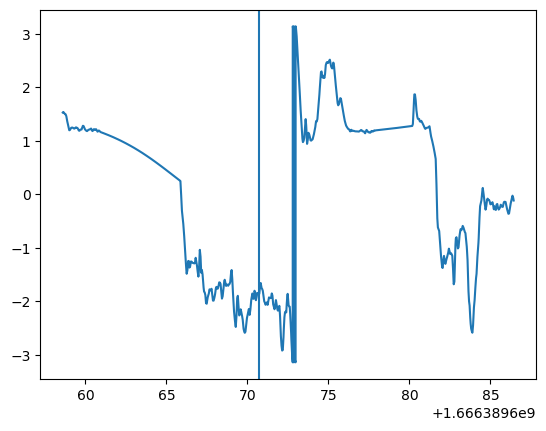

In [44]:
pos_subset = position_info[np.logical_and(np.array(position_info.index)>=t0,
                             np.array(position_info.index)<=t1)]
plt.plot(pos_subset.head_orientation)
plt.axvline(turnaround_times[0][0])

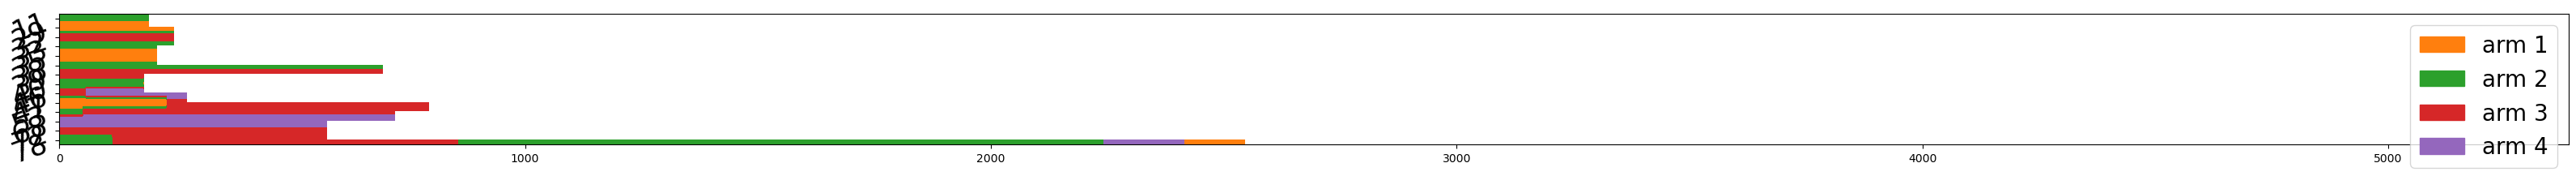

In [99]:
from matplotlib import colors
fig,axes=plt.subplots(1,1,figsize=(40, 10),sharey=True)
colormap = colors.ListedColormap(['C1','C2','C3','C4'])
plt.imshow(trials,cmap=colormap,aspect=20)
plt.yticks(np.arange(len(rowID)),rowID,rotation=20,size=25);  # Set text labels and properties.

handles = [plt.Rectangle((0, 0), 0, 0, color=colormap(i-6), label=labels[i]) for i in [6,7,8,9]]
axes.legend(handles = handles,prop={'size': 20})

### 2. Plot decode

In [263]:
# load decode result, spiking data, theta LFP, mua.

[15:14:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [59]:
decode_options = {}

if animal == "eliot":
    decode_options["encoding_set"] = '2Dheadspeed_above_4_andlowmua'
    decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
    decode_options["decode_threshold_method"] = 'MUA_0SD'
    decode_options["causal"] = False
else:
    decode_options["encoding_set"] = '2Dheadspeed_above_4'
    decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
    decode_options["decode_threshold_method"] = 'MUA_M05SD'
    decode_options["causal"] = False

In [405]:
(log_df,decode,head_speed,head_orientation,
            linear_position_df,lfp_df,theta_df,ripple_df,neural_df,mua_xr,mua_threshold,spikeColInd) = load_epoch_data_wrapper(
                nwb_copy_file_name, session_name, position_name, decode_options)

epoch name 04_Seq2Session2
epoch_pos_name pos 3 valid times


[2024-12-09 21:30:42,769][WARNING]: Skipped checksum for file with hash: 65756212-f56e-fc3c-339a-369742efcaf5, and path: /stelmo/nwb/analysis/eliot20221021/eliot20221021_O0JEUX5SSA.nwb


In [413]:
def findDirectionPlot(t,log_df,linear_position_info,position_info):
    start = log_df.loc[t,'timestamp_H']
    end = log_df.loc[t,'timestamp_O']
    trialInd = (linear_position_info.index >= start) & (linear_position_info.index <= end)
    trialInfo = linear_position_info.loc[trialInd]
    trialInfo2D = position_info.loc[trialInd]
    
    arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
    return arm_direction_t, arm_direction, all_arms_direction

In [62]:
def findPlottingStartEnd(t,log_df,linear_position_info):
    start = log_df.loc[t,'timestamp_H']
    end = log_df.loc[t,'timestamp_O']
    trialInd = (linear_position_info.index >= start) & (linear_position_info.index <= end)
    trialLinearInfo = linear_position_info.loc[trialInd]
    trialPosInfo = trialLinearInfo.loc[:,'track_segment_id']
    start_time_ind = np.argwhere(trialPosInfo >= 6).ravel()[0] #outer arm
    trialPosInfo = trialLinearInfo.iloc[start_time_ind:]
    return [trialPosInfo.index[0]-1,trialPosInfo.index[-1]+2]

In [63]:
def findTurnAround_t(t,rowID, turnaround_times):
    """this is for plotting only, just add 40ms to the left and to the right for camera sampling error."""
    turnaround_t = turnaround_times[np.argwhere(np.array(rowID) == t).ravel()[0]]
    turnaround_array = np.zeros((len(turnaround_t),2))
    turnaround_array[:,0] = np.array(turnaround_t) - 0.04
    turnaround_array[:,1] = np.array(turnaround_t) + 0.04
    
    return turnaround_array

In [65]:
output_folder = f'/cumulus/shijie/recording_pilot/{animal}/changeOfMind'


In [66]:
log_df[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,current,future_H,future_O,past,past_reward
1,1.666389e+09,1.0,1.666389e+09,1.0,1.0,1.0,1.0,4.0,NaN,NaN
2,1.666389e+09,1.0,1.666389e+09,4.0,1.0,4.0,4.0,3.0,1.0,NaN
3,1.666389e+09,1.0,1.666389e+09,3.0,2.0,3.0,3.0,2.0,4.0,NaN
4,1.666389e+09,1.0,1.666389e+09,2.0,1.0,2.0,2.0,4.0,3.0,3.0
5,1.666389e+09,1.0,1.666389e+09,4.0,2.0,4.0,4.0,1.0,2.0,3.0
6,1.666389e+09,1.0,1.666389e+09,1.0,1.0,1.0,1.0,3.0,4.0,4.0
7,1.666389e+09,1.0,1.666389e+09,3.0,1.0,3.0,3.0,2.0,1.0,4.0
8,1.666389e+09,1.0,1.666389e+09,2.0,2.0,2.0,2.0,4.0,3.0,4.0
9,1.666389e+09,1.0,1.666389e+09,4.0,1.0,4.0,4.0,1.0,2.0,2.0
10,1.666389e+09,1.0,1.666389e+09,1.0,2.0,1.0,1.0,4.0,4.0,2.0


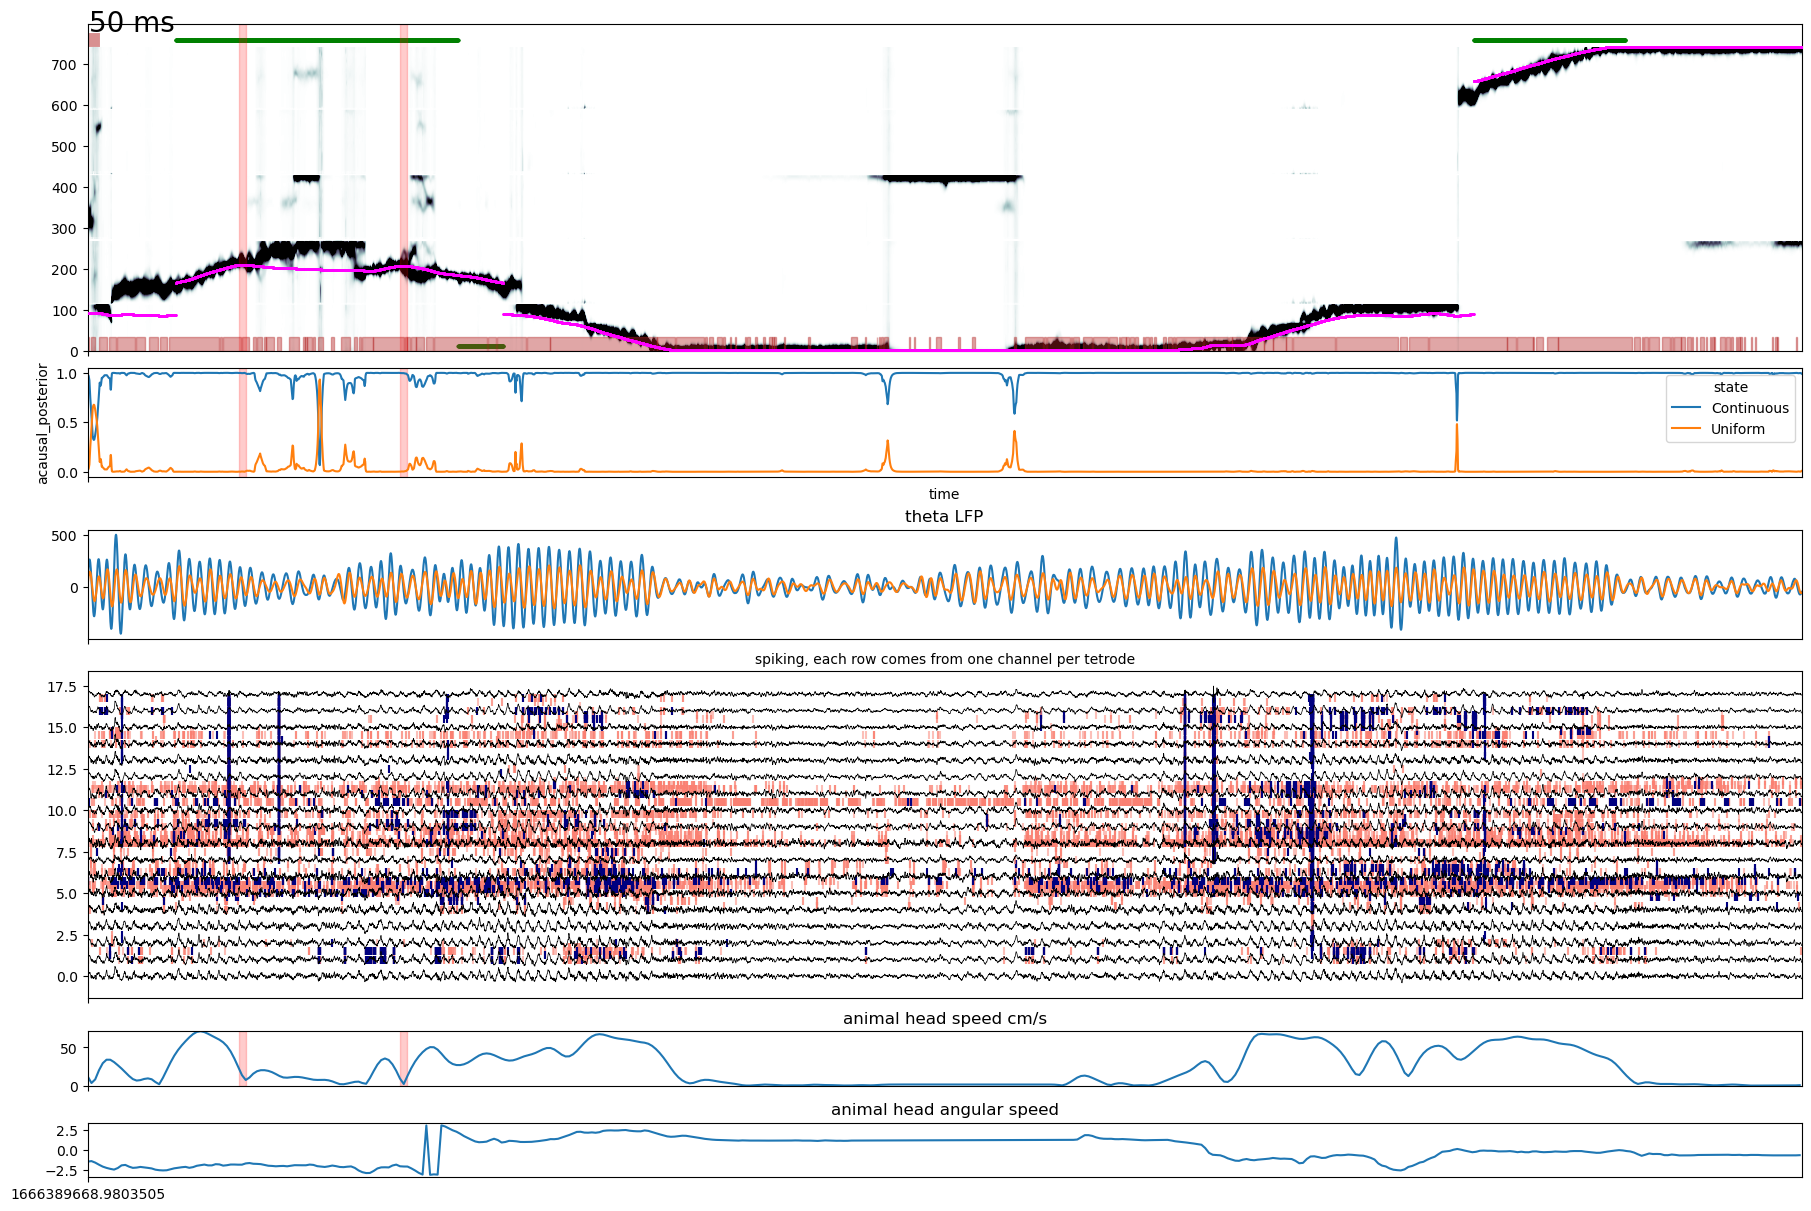

In [462]:
for t in [29]:#rowID:
    plottimes = findPlottingStartEnd(t,log_df,linear_position_info)
    turnaround_t = findTurnAround_t(t,rowID, turnaround_times)
    arm_direction_t, arm_direction, _ = findDirectionPlot(t,linear_position_info,position_info)
    head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)

    filename = animal+'_'+nwb_file_name+'_'+session_name+'_trial'+str(t)
    plot_decode_spiking(plottimes,[],linear_position_df,decode,lfp_df,theta_df,
          neural_df,mua_xr,head_speed,head_orientation,
          ripple_consensus_trace=None,
          title = '', savefolder = output_folder, savename = filename,
          simple = True, tetrode2ind = spikeColInd, likelihood = False,mua_thresh=mua_threshold,causal = decode_options["causal"],
                    plot_spiking=True,plot_changeofmind = True, turnaround = turnaround_t, head_direction_sign = head_direction_sign)

### 3. Make video

In [430]:
import os
os.environ["SPYGLASS_VIDEO_DIR"] = '/stelmo/nwb/video/'
import warnings
warnings.filterwarnings("ignore")

raw_dir = '/stelmo/nwb/raw'
import pynwb

from spyglass.common.common_behav import VideoFile
import cv2 

In [431]:
### make sure there are video files in Spyglass
VideoFile & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),video_file_num,camera_name,video_file_object_id the object id of the file object
eliot20221021_.nwb,1,0,,2091bd53-a9d6-4347-a92e-3e46c787b1ee
eliot20221021_.nwb,2,0,,f4d0b2e9-5272-4ef2-acd9-95d46308ddd2
eliot20221021_.nwb,3,0,,baae0afb-36e2-429c-a8e1-f45a35cdfdca
eliot20221021_.nwb,4,0,,fa9d7718-2aec-4cbd-b876-ec77b0e0de77
eliot20221021_.nwb,5,0,,4cb09ccc-79ee-49ab-a1af-accc38b04f0c
eliot20221021_.nwb,6,0,,31027cbf-c933-4aa7-a9fc-2d2fc6cd1f58
eliot20221021_.nwb,7,0,,bb56cbac-fd15-4878-b0b1-60dd90320b31
eliot20221021_.nwb,8,0,,966261f5-62bd-41a2-ac60-dff133966dce
eliot20221021_.nwb,9,0,,4fba55ff-53ae-492b-a63a-b4a298da9f4b


In [432]:
def load_session_videoInfo(nwb_copy_file_name, position_name):
    epochInd = (EpochPos & {'nwb_file_name':nwb_copy_file_name,
                            'position_interval':position_name}).fetch1("epoch")

    key = {'nwb_file_name': nwb_copy_file_name,'epoch':epochInd}
    
    # video path
    videoPath = VideoFile.get_abs_path(key)
    video_info = (VideoFile & key).fetch1()
    
    # parent underscore version nwb path
    nwb_path = f"{raw_dir}/{video_info['nwb_file_name']}"
    
    # load video timestamp from parent underscore version nwb
    with pynwb.NWBHDF5IO(path=nwb_path, mode="r") as in_out:
        nwb_file = in_out.read()
        nwb_video = nwb_file.objects[video_info["video_file_object_id"]]
        video_filepath = VideoFile.get_abs_path(
            {"nwb_file_name": key["nwb_file_name"], "epoch": key["epoch"]}
        )
        video_dir = os.path.dirname(video_filepath) + "/"
        video_filename = video_filepath.split(video_dir)[-1]
        meters_per_pixel = nwb_video.device.meters_per_pixel
        timestamps = np.asarray(nwb_video.timestamps)
    
    # load session video
    cap = cv2.VideoCapture(video_dir+video_filename)

    return timestamps.copy(), cap

In [433]:
def create_directory_if_not_exists(directory_path):
    """Creates a directory if it doesn't exist."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [449]:
t = 38

timestamps, cap = load_session_videoInfo(nwb_copy_file_name, position_name)

t0 = log_df.loc[t,'timestamp_H']
t1 = log_df.loc[t,'timestamp_O']
if np.isnan(t0): #ilegal trials
    t0 = t1-12 #seconds

animal = nwb_copy_file_name[:5]
video_folder = f'/cumulus/shijie/recording_pilot/{animal}/changeOfMind'
create_directory_if_not_exists(video_folder)

video_path=os.path.join(video_folder,
                        nwb_copy_file_name+'_'+session_name+'_trial'+str(t))

frameToPlot = np.argwhere(np.logical_and(timestamps>=t0,timestamps<=t1)).ravel()
frame0 = frameToPlot[0]
frameLast = frameToPlot[-1]

fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
frameSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(video_path+'.mp4', fourcc, fps, frameSize)

for fi in range(len(timestamps)):##len(frameToPlot)):
    ret, frame = cap.read()
    if fi >= frame0 and fi <= frameLast:
        out.write(frame)
        
cap.release()
out.release()

Directory '/cumulus/shijie/recording_pilot/eliot/changeOfMind' already exists.


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### useful commands to get various marginal distribution

In [29]:
# useful commands to get various marginal distribution
def position_posterior2arm_posterior(position_posterior,linear_map):
    """lump sums bins of one arm"""
    posterior_by_arm=[]
    for a in [0,3,5,7,9]: #home, arm1, arm2, arm3, arm4
        mask_pos = ((position_posterior.position >= linear_map[a,0])
                    & (position_posterior.position <= linear_map[a,1]))
        posterior_arm=position_posterior.isel(position=mask_pos).sum('position')

        posterior_by_arm.append(np.array(posterior_arm))
    posterior_by_arm = np.array(posterior_by_arm)

    return posterior_by_arm

In [ ]:
# useful commands to get various marginal distribution
from spyglass.shijiegu.helpers import interpolate_to_new_time

""" get state posterior """
# state_posterior=np.array(posterior.sum('position'))

""" get position posterior """
#if causal:
#    position_posterior=decode.isel(time=mask_time).causal_posterior.sum('state')
#else:
#    position_posterior=decode.isel(time=mask_time).acausal_posterior.sum('state')

""" get posterior_by_arm """
#posterior_by_arm = position_posterior2arm_posterior(position_posterior,linear_map)
# mua_downsample = (interpolate_to_new_time(mua_xr.to_dataframe(), decode.time)).to_xarray()
#mua_portion = mua_downsample.isel(time=mask_time).mua
#valid_ind = np.array(mua_portion >= mua_threshold)
## only mua > threshold time
# posterior_by_arm = posterior_by_arm[:, valid_ind]

## Next steps:
1. make a more stringent segment classification function, for example, the rat needs to be in more than half of portions of the arm.
2. write a function to obtain the timestamp when the rat turns around.